# COVID-19 Predviduvanje na brojot na novo zaboleni luge

In [1]:
import matplotlib.pyplot as plt #Libraries for visualization
import seaborn as sns
import numpy as np #Library for numerical calculations
from scipy import stats #Library for statistical analysis 
from sklearn.model_selection import train_test_split 
from keras import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge #Importing the linear regression models
from sklearn.metrics import mean_squared_error #For evaluation of the models
from bs4 import BeautifulSoup
from sklearn import metrics
from sklearn.svm import SVR
from keras.layers import LSTM, Dense, Dropout
import requests
import csv
import os
import pandas as pd
import datetime
import re
import sys
import time

%matplotlib notebook

Using TensorFlow backend.


# 1.Собирање на податоците од владата

vladata gi ima podatocite na "https://koronavirus.gov.mk/en" , no tie podatoci se povrzani so nadvoresna data baza, zared toa tie se skrieni i od inspect elements.
    Zatoa ke gi soberam podatocite od oficijalnata strana na wikipedia link "https://en.wikipedia.org/wiki/COVID-19_pandemic_in_North_Macedonia" , koja e azurirana so podatoci od "http://zdravstvo.gov.mk/"

## 1.1 So beautiful soup bibliotekata ke ja parsirame i sobereme potrebnite podatoci, na stranicata ima tabela so site informacii za zarazeni,izleceni i aktivni slucaevi, sekoj red oznacuva datata.Posle koga ke gi soberam site podatoci, ke kreiram CSV file.

In [2]:
source = requests.get('https://en.wikipedia.org/wiki/COVID-19_pandemic_in_North_Macedonia').text
soup = BeautifulSoup(source, 'lxml')
# tabelata koja gi ima site podatoci
tabela = soup.findAll('tbody')
#print(tabela[1])

Data= []
#vkpuno aktivni do toj den
AktivniSlucaevi=[]
#vkupno izleceni do toj den
Izleceni = []
#vkupno zaginati do toj den
Zaginati = []
#od tabelata gi vadime site redovi(za sekoja data)
rows = soup.findAll('table')[1].findAll('tr')

# od 4tata redica pocnuvaat podatocite
for i in range(4,len(rows)-1):
    flag1=0
    flag2=0
    flag3=0
    #ja zimame datata od sekoja redica
    Data.append(rows[i].findAll('td')[0].text)
    divovi = rows[i].findAll('td')[1].findAll('div')
    for j in range(0,len(divovi)):
        # go naogame podatokot za Aktivni slucaevi
        if "Tomato" in divovi[j]['style']:
            AktivniSlucaevi.append(divovi[j]['title'])
            flag1=1
        # go naogame podatokot za Izleceni slucaevi
        if "SkyBlue" in divovi[j]['style']:
            Izleceni.append(divovi[j]['title'])
            flag2=1
        # go naogame podatokot za Zaginati
        if "A50026" in divovi[j]['style']:
            Zaginati.append(divovi[j]['title'])
            flag3=1
            
    # ovie 3 if se za ako za daden den nema specificen slucaj, dodadi 0 vo listata, za da ne e prazno
    if (flag1==0):
        AktivniSlucaevi.append(0)
    if (flag2==0):
        Izleceni.append(0)
    if (flag3==0):
        Zaginati.append(0)
    
     
print("Dati:",Data) 
print("-----------")
print("Aktivni slucaevi:",AktivniSlucaevi)
print("-----------")
print("Izleceni:",Izleceni)
print("-----------")
print("Zaginati:",Zaginati)
  
for i in range(1,len(Data)):
    # formula, presmetka za novo-Zarazen za toj den
    den=int(AktivniSlucaevi[i])-int(AktivniSlucaevi[i-1])+int(Izleceni[i])-int(Izleceni[i-1])+int(Zaginati[i])-int(Zaginati[i-1])
    # presmetka za novo-Izlecen za toj den
    rden = int(Izleceni[i])-int(Izleceni[i-1])
    # presmetka za novo-Zaginat za toj den
    zden = int(Zaginati[i])-int(Zaginati[i-1])

Dati: ['2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16', '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20', '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29', '2020-03-30', '2020-03-31', '2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05', '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09', '2020-04-10', '2020-04-11', '2020-04-12', '2020-04-13', '2020-04-14', '2020-04-15', '2020-04-16', '2020-04-17', '2020-04-18', '2020-04-19', '2020-04-20', '2020-04-21', '2020-04-22', '2020-04-23', '2020-04-24', '2020-04-25', '2020-04-26', '2020-04-27', '2020-04-28', '2020-04-29', '2020-04-30', '2020-05-01', '2020-05-02', '2020-05-03', '2020-05-04', '2020-05-05', '2020-05-06', '2020-05-07', '2020-05-08', '2020-05-09', '2020-05-10', '2020-05-11', '2020-05-12', '2020-05-13']
-----------
Aktivni slucaev

## 1.2 Sega odkako gi imame site podatocite od 6ti mart do 12ti maj, ke gi napravime vo CSV file, ovie podatoci se sevkupni podatoci do toj den! 

In [37]:
#kreirame novo CSV za sevkpuni slucaevi do toj den 
with open('Covid-19-MKD.csv', 'w') as f:
    fieldnames = ['Date','Zarazeni','Izleceni','Pocinati']
    thewriter = csv.DictWriter(f,fieldnames=fieldnames)
    thewriter.writeheader()
    
    for i in range(0,len(Data)):
        #dodavanje na podatocite vo CSV
        broj = int(AktivniSlucaevi[i])+int(Izleceni[i])+int(Zaginati[i])
        thewriter.writerow({'Date' : str(Data[i]),'Zarazeni' : str(broj), 'Izleceni': str(Izleceni[i]), 'Pocinati' : str(Zaginati[i])})

## 1.3 Ke napravam i drug CSV file kade sega ovde ke gi imam site podatoci no samo za toj den!

In [38]:
# kreirame novo CSV za novi-slucaevi za toj den, ovoj ke go koristime za treniranjeto
with open('Poseben-Den-Covid-19-MKD.csv', 'w') as f:
    fieldnames = ['Date','novo-Zarazeni','novo-Izleceni','novo-Pocinati']
    thewriter = csv.DictWriter(f,fieldnames=fieldnames)
    thewriter.writeheader()
    thewriter.writerow({'Date': "2020-03-06",'novo-Zarazeni' : '2','novo-Izleceni': '0','novo-Pocinati' : '0'})
    
    for i in range(1,len(Data)):
        den=int(AktivniSlucaevi[i])-int(AktivniSlucaevi[i-1])+int(Izleceni[i])-int(Izleceni[i-1])+int(Zaginati[i])-int(Zaginati[i-1])
        rden = int(Izleceni[i])-int(Izleceni[i-1])
        zden = int(Zaginati[i])-int(Zaginati[i-1])
        thewriter.writerow({'Date' : str(Data[i]),'novo-Zarazeni' : str(den), 'novo-Izleceni': str(rden), 'novo-Pocinati' : str(zden)})    

# 2. Importiranje na kreiraniot CSV file

In [14]:
df = pd.read_csv('Poseben-Den-Covid-19-MKD.csv',index_col="Date",parse_dates=True)
dufus=df
df.shape
number_of_features=2
df.tail(10)

,novo-Zarazeni,novo-Izleceni,novo-Pocinati
Date,,,
2020-05-04,7,47,1
2020-05-05,8,21,1
2020-05-06,13,44,2
2020-05-07,33,22,1
2020-05-08,14,20,1
2020-05-09,36,13,1
2020-05-10,20,24,0
2020-05-11,22,64,0
2020-05-12,10,5,1


 Imame malo podatocno mnozesto, atributite t.e faktorite od koj zavisat novo zarazenite se mnogu kompleksni, pa zatoa   rezultatite koi ke gi dobieme, nema da se premnogu precizni.
 Bidejki predviduvame vrednost, ke istreniram modeli so Logisticka regresija i Support Vector Regresija

# 3. Vizuelizacija

## 3.1 Plot od atributite

<IPython.core.display.Javascript object>


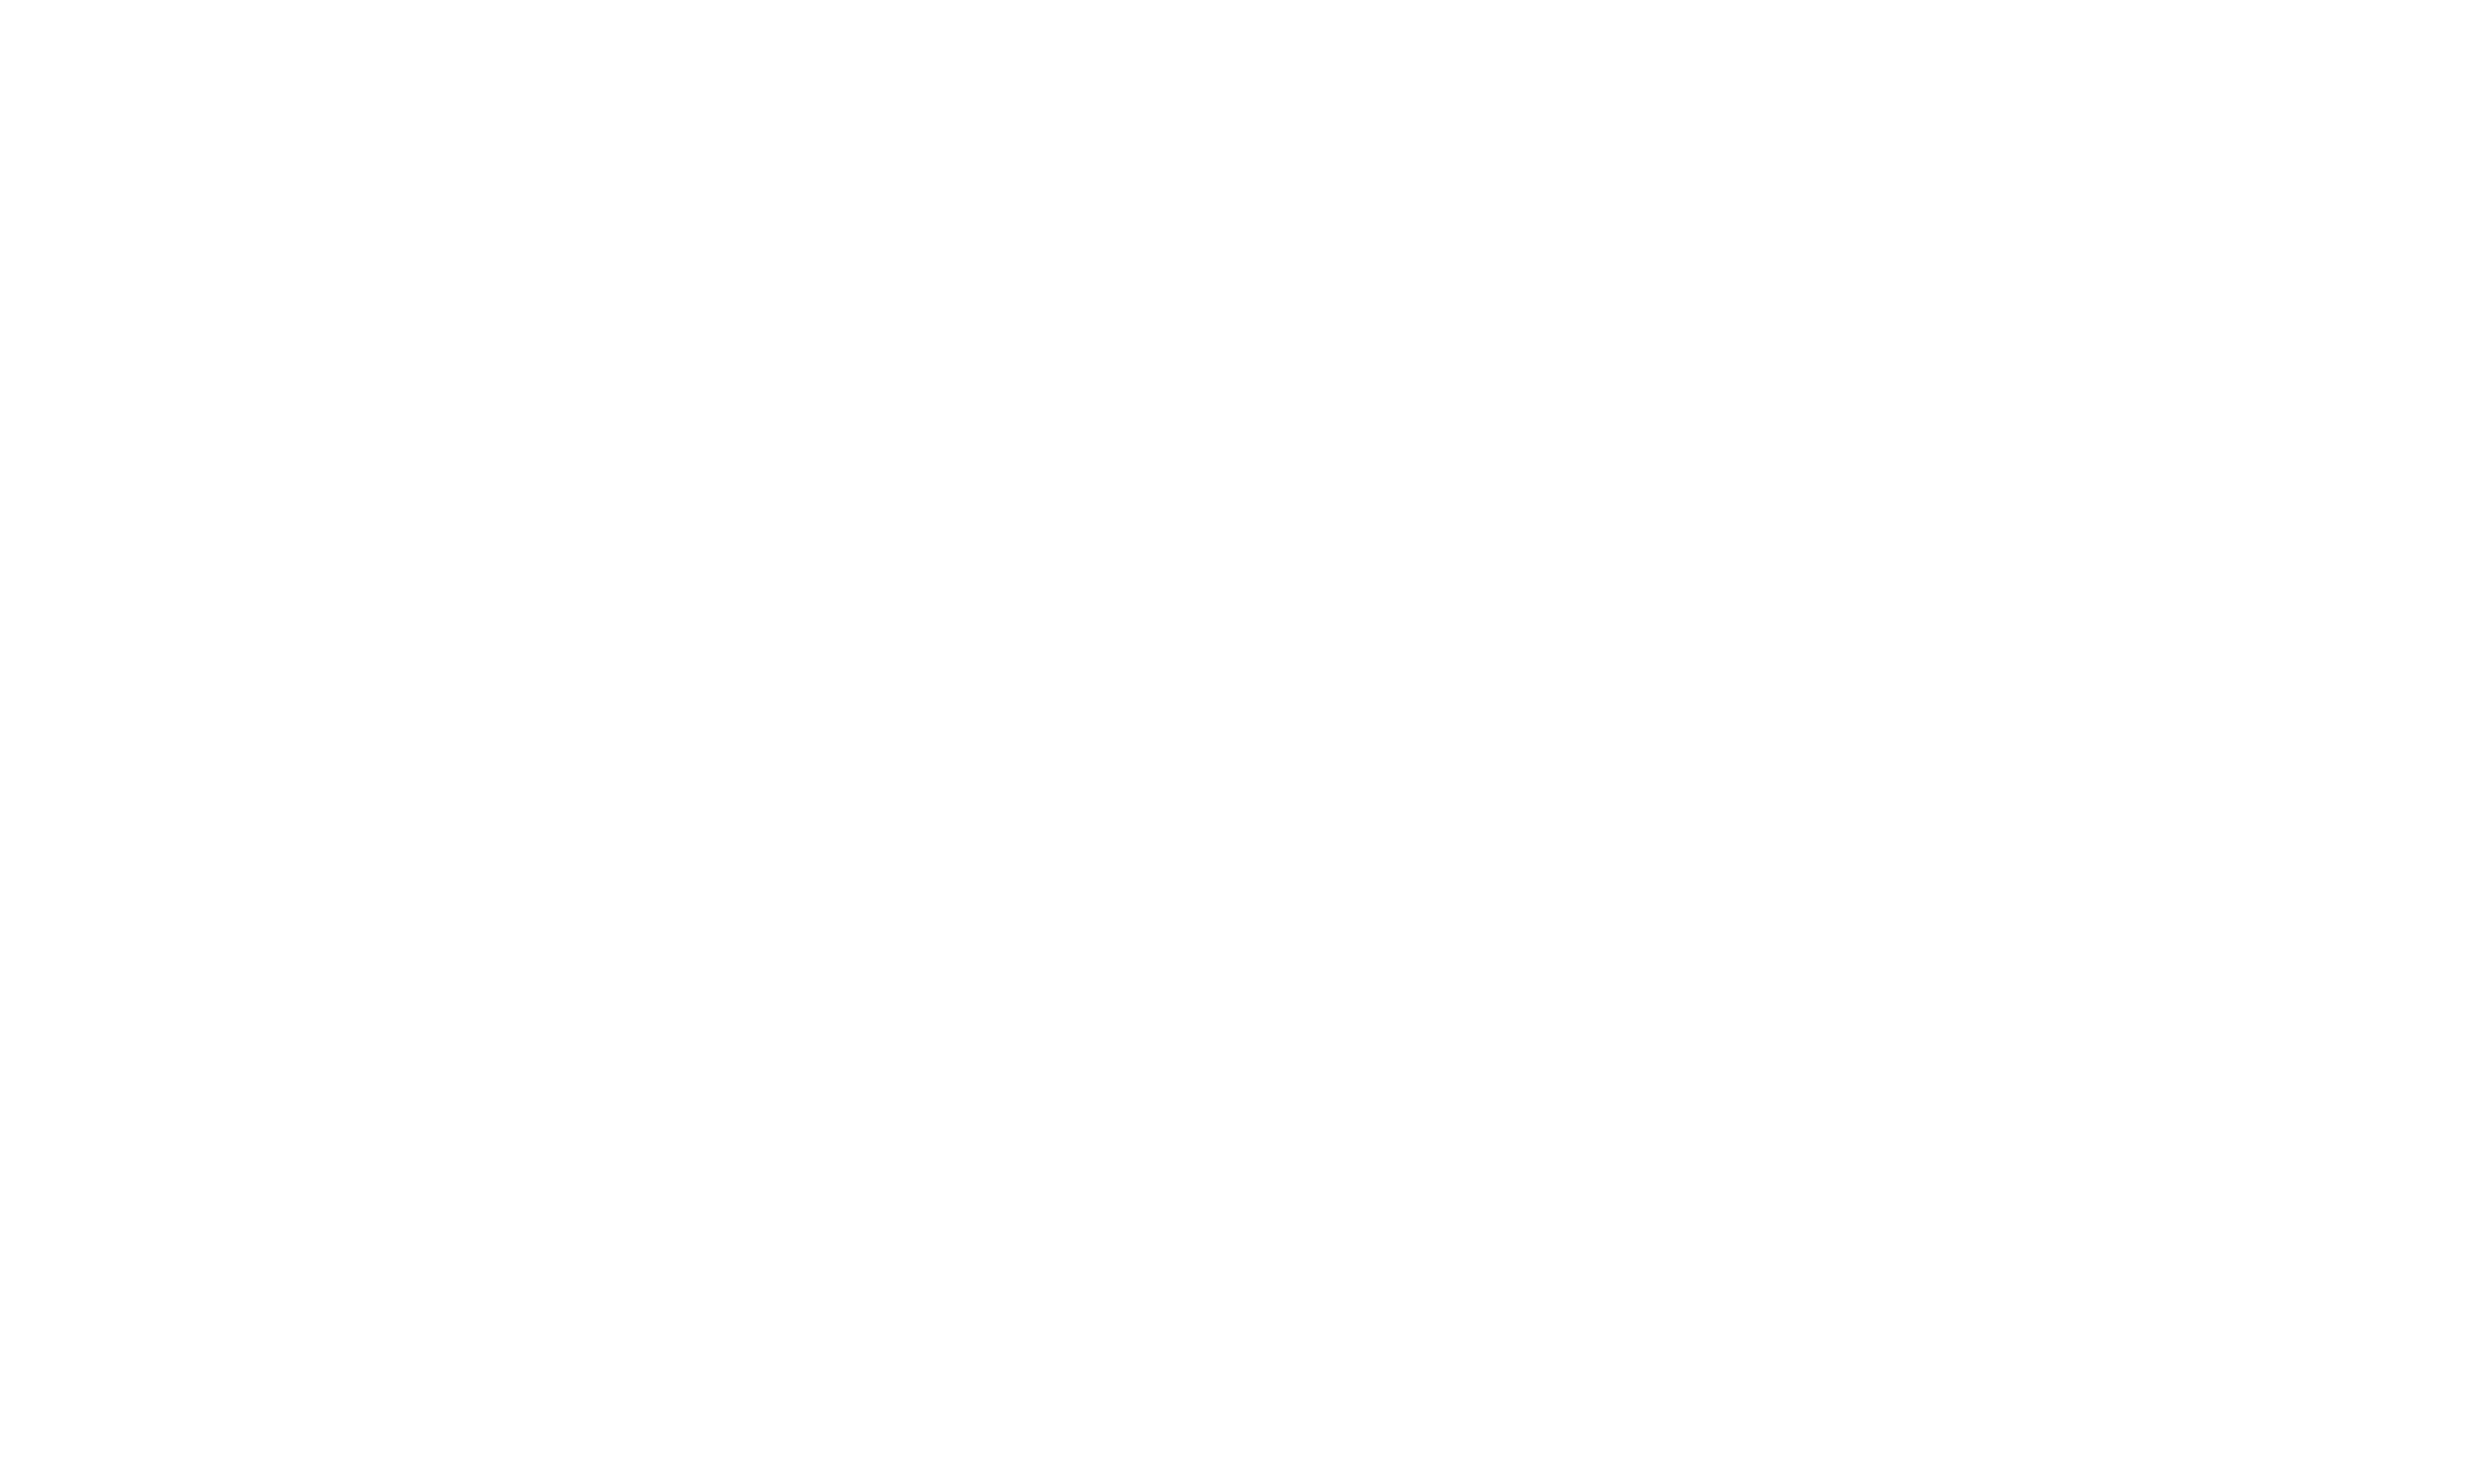

<IPython.core.display.Javascript object>


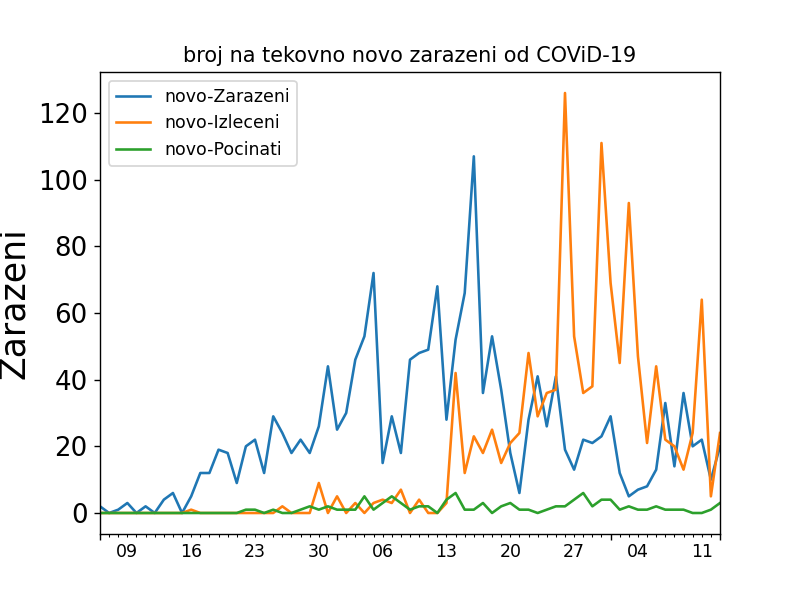

In [6]:
plt.figure(figsize=(20,12))
df.plot()
plt.title ('broj na tekovno novo zarazeni od COViD-19')
plt.xlabel('Denovi',size=20)
plt.ylabel('Zarazeni',size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

## 3.2 korelaciski matarix, Korelacija pomegu atributite 

<IPython.core.display.Javascript object>


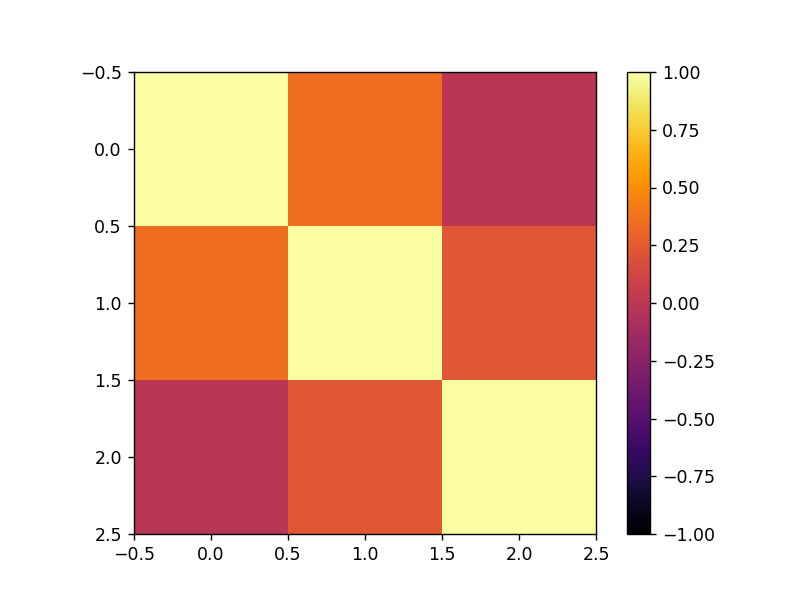

In [7]:
correlation_matrix = np.ones((number_of_features +1 ,number_of_features +1))
for i in range(number_of_features): 
    measure = np.array(df.drop('novo-Zarazeni', 1).iloc[:,i])
    for j in range(number_of_features):
        measure2 = np.array(df.drop('novo-Zarazeni', 1).iloc[:,j])
        corr, _ = stats.pearsonr(measure, measure2)
        correlation_matrix[i][j] = corr

for i in range(number_of_features): 
    measure = np.array(df.drop('novo-Zarazeni', 1).iloc[:,i])
    j = number_of_features
    measure2 = np.array(df.iloc[:,0])
    corr, _ = stats.pearsonr(measure, measure2)
    correlation_matrix[i][j] = corr
    correlation_matrix[j][i] = corr

plt.figure()
plt.imshow(correlation_matrix, cmap = "inferno", vmin=-1, vmax=1) 
plt.colorbar()
plt.show()

# 4. Data pred procesiranje

In [8]:
df.isnull().any()
# nemame nikakvi null valuti, se e vo red

novo-Zarazeni    False
novo-Izleceni    False
novo-Pocinati    False
dtype: bool

In [15]:
# podatocite ni se mali, ne variraat premnogu , pa nema da ni e potrebno MinMax skaliranje.
# future_day ke ni e denvoi za kolku ponatamu sakame da predvideme

future_day=1
#statisticki informacii
df.describe()

,novo-Zarazeni,novo-Izleceni,novo-Pocinati
count,69.000000,69.000000,69.000000
mean,24.536232,17.811594,1.376812
std,20.094321,26.807744,1.544454
min,0.000000,0.000000,0.000000
25%,12.000000,0.000000,0.000000
50%,20.000000,4.000000,1.000000
75%,33.000000,24.000000,2.000000
max,107.000000,126.000000,6.000000


In [16]:
# kreiram nov atribut, kade ke gi napolnam infomaciite za predvidenite novi denovi

# so ovaa go pomestuvam nazad 1 den podatocnoto mnozesto za toj atribut kade ke treba da go predvidam toj den
df['Predvideno-Zarazeni']=df[['novo-Zarazeni']].shift(-future_day)

df.tail()

,novo-Zarazeni,novo-Izleceni,novo-Pocinati,Predvideno-Zarazeni
Date,,,,
2020-05-09,36,13,1,20.0
2020-05-10,20,24,0,22.0
2020-05-11,22,64,0,10.0
2020-05-12,10,5,1,20.0
2020-05-13,20,24,3,NaN


In [20]:
# kreirame ja zavistana promenliva X, atribut ke bide novo-zarazeni
# Ke ja konverirame pandas dataframot vo numpy array
X = np.array(df[['novo-Zarazeni']])

# Spored pogornite vizuelni predstavuvanja, moze da zabelezeme deka moze da gi iskorisite izlecenite i pocinatite da modelirame.
# go briseme posledniot den, bidejki treba da go predvideme
X = X[:-future_day]
print(X)

[[  2]
 [  0]
 [  1]
 [  3]
 [  0]
 [  2]
 [  0]
 [  4]
 [  6]
 [  0]
 [  5]
 [ 12]
 [ 12]
 [ 19]
 [ 18]
 [  9]
 [ 20]
 [ 22]
 [ 12]
 [ 29]
 [ 24]
 [ 18]
 [ 22]
 [ 18]
 [ 26]
 [ 44]
 [ 25]
 [ 30]
 [ 46]
 [ 53]
 [ 72]
 [ 15]
 [ 29]
 [ 18]
 [ 46]
 [ 48]
 [ 49]
 [ 68]
 [ 28]
 [ 52]
 [ 66]
 [107]
 [ 36]
 [ 53]
 [ 37]
 [ 18]
 [  6]
 [ 28]
 [ 41]
 [ 26]
 [ 41]
 [ 19]
 [ 13]
 [ 22]
 [ 21]
 [ 23]
 [ 29]
 [ 12]
 [  5]
 [  7]
 [  8]
 [ 13]
 [ 33]
 [ 14]
 [ 36]
 [ 20]
 [ 22]
 [ 10]]


In [21]:
# ke ja kreirame zavisnata promenliva y, atributot novo-zarazeni koj bese premesten za 1 den 
y=np.array(df['Predvideno-Zarazeni'])
# bez poslednoto
y = y[:-future_day]
print(y)

[  0.   1.   3.   0.   2.   0.   4.   6.   0.   5.  12.  12.  19.  18.
   9.  20.  22.  12.  29.  24.  18.  22.  18.  26.  44.  25.  30.  46.
  53.  72.  15.  29.  18.  46.  48.  49.  68.  28.  52.  66. 107.  36.
  53.  37.  18.   6.  28.  41.  26.  41.  19.  13.  22.  21.  23.  29.
  12.   5.   7.   8.  13.  33.  14.  36.  20.  22.  10.  20.]


In [22]:
# Bidejki rabotime so vreme, podatocite nemozeme random da gi podelime, mora da odat po redosled spored denovi
# zatoa nema da koristime train_test_split
# podatocnoto mnozesto ke go podelime na 80% treniracko i  20% testiracko
x_train = X[:int(X.shape[0]*0.8)]
x_test = X[int(X.shape[0]*0.8):]
y_train = y[:int(X.shape[0]*0.8)]
y_test = y[int(X.shape[0]*0.8):]
#x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
print(x_test)

[[21]
 [23]
 [29]
 [12]
 [ 5]
 [ 7]
 [ 8]
 [13]
 [33]
 [14]
 [36]
 [20]
 [22]
 [10]]


# 5. Treniranje na modelite

## 5.1 Linearna regresija

In [23]:
lr_model = LinearRegression()

lr_model.fit(x_train,y_train)

LinearRegression()

In [24]:
lr_confidence = lr_model.score(x_test,y_test)
print("lr confidence: ", lr_confidence)


lr confidence:  -0.3535369650965803


In [39]:
# predviduvanje na naredniot den so linearna regresija
x_future = np.array(df[['novo-Zarazeni']])[-future_day:]
print ("Linearna regresija: Vistinsko zarazeni na naredniot den ",df['novo-Zarazeni'][-1])

#predviduvanje so linearnata regresija za naredniot den (12.05.2020)
lr_prediction = lr_model.predict(x_future)
print("Linearna regresija: Predvideno novo-zarazeni za naredniot den ",int(lr_prediction))
lr_prediction_snow = lr_model.predict(np.array(df[['novo-Zarazeni']]))

Linearna regresija: Vistinsko zarazeni na naredniot den  20
Linearna regresija: Predvideno novo-zarazeni za naredniot den  22


<IPython.core.display.Javascript object>


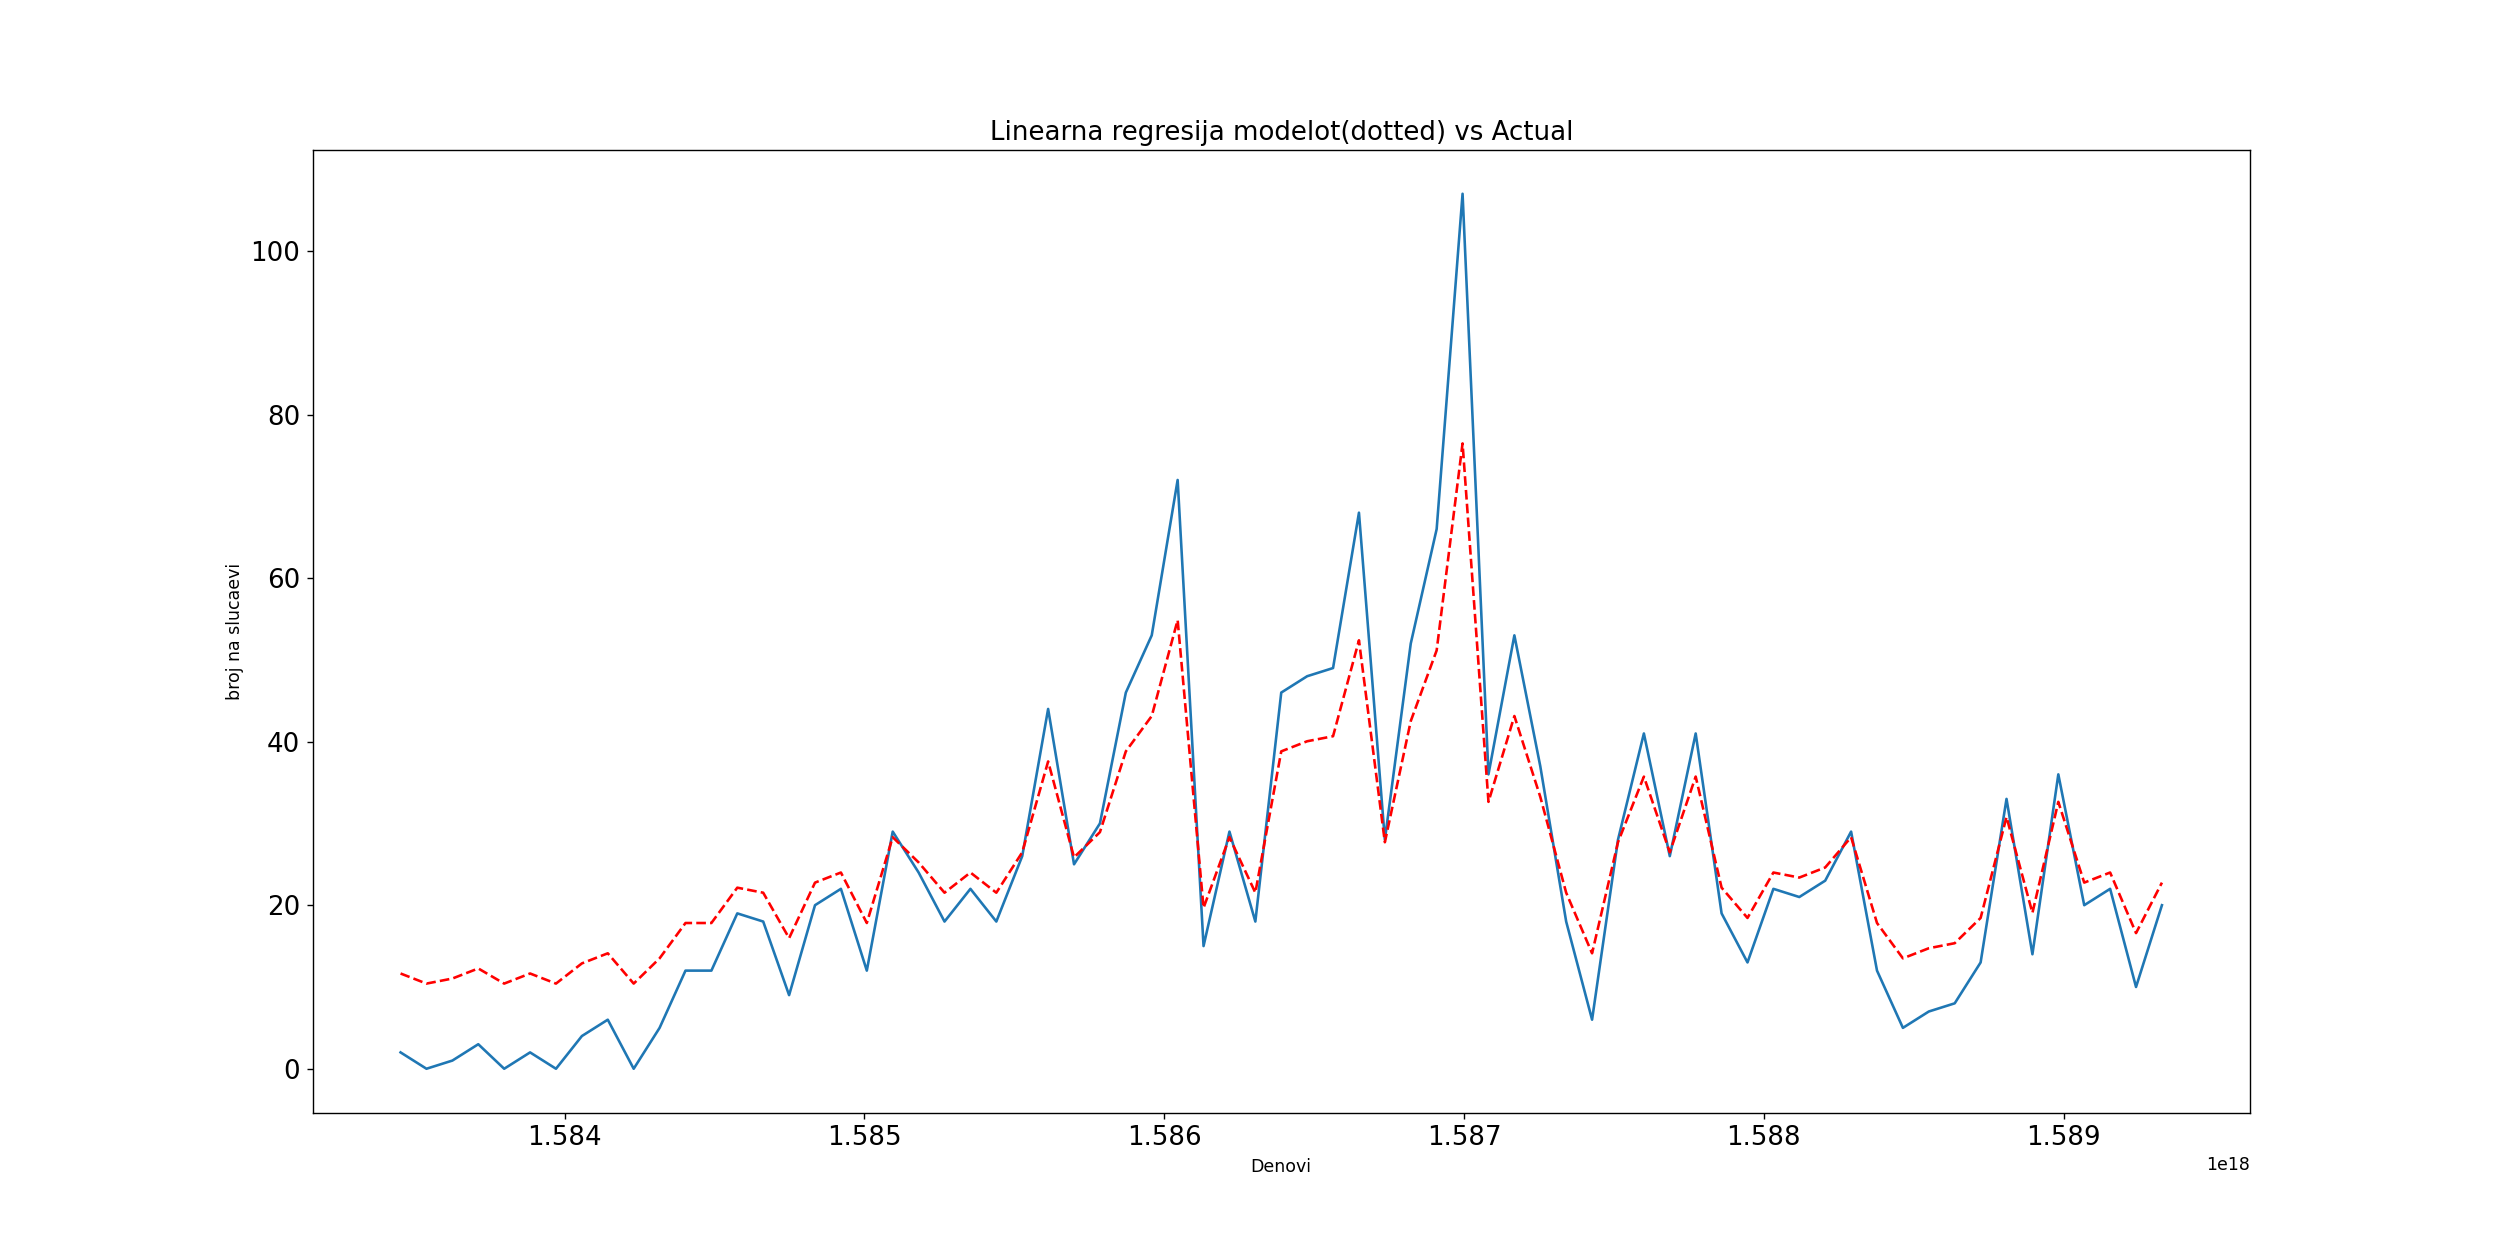

In [28]:
plt.figure(figsize=(20,10))
plt.plot(df.index.values.tolist() ,df['novo-Zarazeni'])
plt.plot(df.index.values.tolist() ,np.array(lr_prediction_snow), linestyle='dashed',color='red')
plt.xticks(size=15)
plt.yticks(size=15)
plt.title('Linearna regresija modelot(dotted) vs Actual',size=15)
plt.xlabel('Denovi')
plt.ylabel('broj na slucaevi')
plt.show()

Linearn reggresion modelot e premnogu precizen za trenirackite podatocite, imame naklonuvanje na overfitting.

## Bidejki ne sum zadovolen tolku so rezultatot. Ke istreniram i recurrent neural network model, potocno LTMS,koj e dobar za time-series podatoci, za ovoj model ke go iskoristam prviot CSV file koj go kreirav so sevkupnite podatoci do toj den 

## 5.2 LTMS model


In [29]:
dfs = pd.read_csv('Covid-19-MKD.csv')
dfs.tail()

,Date,Zarazeni,Izleceni,Pocinati
64,2020-05-09,1622,1112,91
65,2020-05-10,1642,1136,91
66,2020-05-11,1664,1200,91
67,2020-05-12,1674,1205,92
68,2020-05-13,1694,1229,95


In [30]:
# go koristime samo atributot od zarazeni
dat = np.array(dfs['Zarazeni'])
print(dat)

[   3    3    4    7    7    9    9   13   19   19   24   36   48   67
   85   94  114  136  148  177  201  219  241  259  285  329  354  384
  430  483  555  570  599  617  663  711  760  828  856  908  974 1081
 1117 1170 1207 1225 1231 1259 1300 1326 1367 1386 1399 1421 1442 1465
 1494 1506 1511 1518 1526 1539 1572 1586 1622 1642 1664 1674 1694]


In [31]:
# ke predviduvame so 2 cekori na feedback
cekori = 2
X = []
y =[]
for i in range(len(dat)):
    # gi vnesuvame vo X po 2 podatoka, a vo Y po 1, sto e nareden
    kraj = i + cekori
    if kraj > len(dat) -1:
        break
    podX, podY = dat[i:kraj], dat[kraj]
    y.append(podY)
    X.append(podX)
X= np.array(X)
y = np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))
print (y)

[   4    7    7    9    9   13   19   19   24   36   48   67   85   94
  114  136  148  177  201  219  241  259  285  329  354  384  430  483
  555  570  599  617  663  711  760  828  856  908  974 1081 1117 1170
 1207 1225 1231 1259 1300 1326 1367 1386 1399 1421 1442 1465 1494 1506
 1511 1518 1526 1539 1572 1586 1622 1642 1664 1674 1694]


In [32]:
# modelo go kreirame
model = Sequential()

model.add(LSTM(40, activation='relu', return_sequences=True, input_shape=(2, 1)))

model.add(LSTM(40, activation='relu'))

model.add(Dense(1))


In [33]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [34]:
model.fit(X,y,epochs=150,verbose=0)

In [36]:
#poslednite 2 dena
x_last_days = np.array([1664, 1674])
x_last_days = x_last_days.reshape((1, 2, 1))

daypredict = model.predict(x_last_days,verbose=0)
print('Naredniot den predviduvame:', int(daypredict),'toa znaci bi imalo',int(daypredict)-1674,' novi-zaboleni')

Naredniot den predviduvame: 1694 toa znaci bi imalo 20  novi-zaboleni


## Izraboteno od Milan Pavikjevikj